# PolyaCleavage parameter grid search

**Purpose**: To identify the optimal PolyaCleavage parameters in *S. cerevisiae* using a comprehensive grid search.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import models

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'cleavage_model_gridsearch')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5,
}

## HELPER FUNCTIONS

In [7]:
def visualize_parameter_effects(species, data, base_model, test_var, test_val = None, test_order = None, control_seed = 'negative_seed', replicates = 5, xlab_type = None, rotate_labels = False, ent_ylim = (0,1), mcp_ylim = (0,1), val_line = None, show_data = True):
    
    ## Filter equivalent models with the single parameter varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ != test_var)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (test_order is not None):
        dt = dt.loc[dt[test_var].isin(test_order)].copy()
    
    if (xlab_type is not None):
        dt[test_var] = dt[test_var].astype(xlab_type)
    
    ## Confirm that all replicates were successfully included
    
    if (replicates is not None) and not (dt.groupby(test_var).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_var).size()))
        
    if not (dt.groupby([test_var,control_seed]).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby([test_var,control_seed]).size()))
        
    ## Highlight selected parameter bar
    
    if (test_val is not None):
        dt['highlight'] = (dt[test_var] == test_val)
    else:
        dt['highlight'] = False
    
    ## Visualize model receiver-operating characteristic curve
    
    nlevels = dt[test_var].nunique()
    norder = test_order if (test_order is not None) else sorted(dt[test_var].unique().tolist())
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'tp_ent_corr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (val_line is not None):
        mean_val = dt.loc[dt[test_var] == test_val, 'tp_ent_corr'].agg(val_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(ent_ylim)
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("TP ENT correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyacleavage_grid_search.{species}.{test_var}.tp_ent_corr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['tp_ent_corr'].agg([val_line,'std']).sort_values(val_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[val_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[val_line].idxmax(), val_line] - summary_data.loc[summary_data[val_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_val is not None) and (val_line is not None):
        print("\nT-test for differences in TP ENT corr:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'tp_ent_corr'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'tp_ent_corr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} TP ENT corr: pval = {alt_pval:.02E}")
    
    ## Visualize model precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'tp_mcp_corr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (val_line):
        mean_val = dt.loc[dt[test_var] == test_val, 'tp_mcp_corr'].agg(val_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(mcp_ylim)
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("TP MCP correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyacleavage_grid_search.{species}.{test_var}.tp_mcp_corr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['tp_mcp_corr'].agg([val_line,'std']).sort_values(val_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[val_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[val_line].idxmax(), val_line] - summary_data.loc[summary_data[val_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUPRC
    
    if (test_val is not None) and (val_line is not None):
        print("\nT-test for differences in TP MCP corr:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'tp_mcp_corr'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'tp_mcp_corr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} TP MCP corr: pval = {alt_pval:.02E}")
    
    return


In [8]:
## Cartesian product example code from: https://www.geeksforgeeks.org/cartesian-product-of-any-number-of-sets/

def cartesianProduct(set_a, set_b):
    result =[]
    for i in range(0, len(set_a)):
        for j in range(0, len(set_b)):
 
            # for handling case having cartesian
            # product first time of two sets
            if type(set_a[i]) != list:         
                set_a[i] = [set_a[i]]
                 
            # copying all the members
            # of set_a to temp
            temp = [num for num in set_a[i]]
             
            # add member of set_b to 
            # temp to have cartesian product     
            temp.append(set_b[j])             
            result.append(temp)  
             
    return result
 
# Function to do a cartesian 
# product of N sets 
def Cartesian(list_a):
     
    # result of cartesian product
    # of all the sets taken two at a time
    temp = list_a[0]
     
    # do product of N sets 
    for i in range(1, len(list_a)):
        temp = cartesianProduct(temp, list_a[i])
         
    return temp


In [9]:
def visualize_combination_effects(species, data, base_model, test_vars, test_vals = None, test_orders = None, control_seed = 'negative_seed', replicates = 5, xlab_types = None, rotate_labels = False, ent_ylim = (0,1), mcp_ylim = (0,1), val_line = None, show_data = True):
    
    ## Filter equivalent models with the combination parameters varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ not in test_vars)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (xlab_types is not None):
        for (test_var,xlab_type) in zip(test_vars,xlab_types):
            dt[test_var] = dt[test_var].astype(xlab_type)
            
    dt['label'] = dt.apply(lambda row : "-".join([str(row[t]) for t in test_vars]), axis = 1)
    
    ## Confirm that all replicates were successfully included
    
    if (replicates is not None) and not (dt.groupby(test_vars).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_vars).size()))
        
    if not (dt.groupby(test_vars + [control_seed]).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby(test_vars + [control_seed]).size()))
    
    ## Highlight selected parameter bar
    
    if (test_vals is not None):
        dt['highlight'] = (dt['label'] == test_vals)
    else:
        dt['highlight'] = False
        
    ## Visualize model receiver-operating characteristic curve
    
    nlevels = len(dt[test_vars].drop_duplicates())
    
    if (test_orders is not None):
        norder = test_orders
    else:
        norder = ["-".join(_) for _ in Cartesian([dt[test_var].sort_values().unique().astype(str).tolist() for test_var in test_vars]) if ("-".join(_) in dt['label'].unique().tolist())]
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'tp_ent_corr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (val_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'tp_ent_corr'].agg(val_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(ent_ylim)
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("TP ENT correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyacleavage_grid_search.{species}.{test_var}.tp_ent_corr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['tp_ent_corr'].agg([val_line,'std']).sort_values(val_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[val_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[val_line].idxmax(), val_line] - summary_data.loc[summary_data[val_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_vals is not None) and (val_line is not None):
        print("\nT-test for differences in TP ENT corr:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'tp_ent_corr'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'tp_ent_corr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} TP ENT corr: pval = {alt_pval:.02E}")
    
    ## Visualize model precision-recall curve
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'tp_mcp_corr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (val_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'tp_mcp_corr'].agg(val_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(mcp_ylim)
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("TP MCP correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyacleavage_grid_search.{species}.{test_var}.tp_mcp_corr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['tp_mcp_corr'].agg([val_line,'std']).sort_values(val_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[val_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[val_line].idxmax(), val_line] - summary_data.loc[summary_data[val_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUPRC
    
    if (test_vals is not None) and (val_line is not None):
        print("\nT-test for differences in TP MCP corr:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'tp_mcp_corr'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'tp_mcp_corr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} TP MCP corr: pval = {alt_pval:.02E}")
    return


## ANALYSIS

In [10]:
scer_config = {
    'architecture'  : 'cleavage',
    'sequence_size' : 500,
    'conv_units'    : 128,
    'conv_shape'    : 8,
    'lstm_units'    : 32,
    'bin_dropout'   : 0.1,
    'vec_dropout'   : 0.3,
    'learning_rate' : 0.001,
    'kernel_initializer' : 'zeros',
}


### Saccharomyces cerevisiae

#### Parameter grid search

In [11]:
scer_grid = pd.read_csv(os.path.join(RESOURCES, 'polyacleavage_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_grid = scer_grid.loc[scer_grid['modeltype'].str.contains('imbalgrid')]

scer_grid['kfold'] = scer_grid['dataset'].apply(lambda x : x.replace(".txt","").split("kfold_")[-1])

print(scer_grid.shape)


(265, 22)


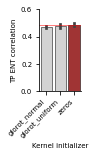


Corresponding data:
                        mean       std        se within1se
kernel_initializer                                        
zeros               0.485730  0.015257  0.006823         *
glorot_uniform      0.475411  0.016550  0.007402          
glorot_normal       0.472070  0.009956  0.004452          

T-test for differences in TP ENT corr:
glorot_normal vs zeros TP ENT corr: pval = 1.32E-01
glorot_uniform vs zeros TP ENT corr: pval = 3.35E-01


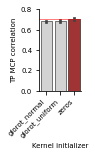


Corresponding data:
                        mean       std        se within1se
kernel_initializer                                        
zeros               0.706456  0.011012  0.004925         *
glorot_uniform      0.685482  0.009939  0.004445          
glorot_normal       0.681715  0.002563  0.001146          

T-test for differences in TP MCP corr:
glorot_normal vs zeros TP MCP corr: pval = 1.20E-03
glorot_uniform vs zeros TP MCP corr: pval = 1.34E-02


In [12]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, scer_config, 
                            'kernel_initializer', 'zeros',
                            control_seed = 'kfold', replicates = 5, rotate_labels = True,
                            val_line = 'mean', ent_ylim = (0,0.6), mcp_ylim = (0,0.8))


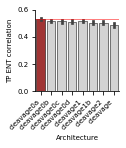


Corresponding data:
                  mean       std        se within1se
architecture                                        
cleavage0a    0.533111  0.010842  0.004849         *
cleavage0b    0.516088  0.013648  0.006103          
cleavage1     0.515013  0.012006  0.005369          
cleavage0c    0.514487  0.013543  0.006056          
cleavage0d    0.511509  0.014959  0.006690          
cleavage1b    0.504302  0.011099  0.004964          
cleavage2     0.502752  0.012945  0.005789          
cleavage      0.485730  0.015257  0.006823          

T-test for differences in TP ENT corr:
cleavage0b vs cleavage0a TP ENT corr: pval = 6.05E-02
cleavage0c vs cleavage0a TP ENT corr: pval = 4.31E-02
cleavage0d vs cleavage0a TP ENT corr: pval = 3.09E-02
cleavage1 vs cleavage0a TP ENT corr: pval = 3.69E-02
cleavage1b vs cleavage0a TP ENT corr: pval = 3.20E-03
cleavage2 vs cleavage0a TP ENT corr: pval = 3.84E-03
cleavage vs cleavage0a TP ENT corr: pval = 4.76E-04


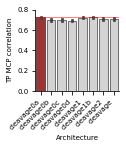


Corresponding data:
                  mean       std        se within1se
architecture                                        
cleavage0a    0.725013  0.007030  0.003144         *
cleavage1b    0.724164  0.007891  0.003529         *
cleavage1     0.718738  0.007904  0.003535          
cleavage      0.706456  0.011012  0.004925          
cleavage2     0.705435  0.017085  0.007641          
cleavage0c    0.698300  0.010891  0.004870          
cleavage0b    0.698127  0.011110  0.004969          
cleavage0d    0.691699  0.005210  0.002330          

T-test for differences in TP MCP corr:
cleavage0b vs cleavage0a TP MCP corr: pval = 1.82E-03
cleavage0c vs cleavage0a TP MCP corr: pval = 1.74E-03
cleavage0d vs cleavage0a TP MCP corr: pval = 2.78E-05
cleavage1 vs cleavage0a TP MCP corr: pval = 2.21E-01
cleavage1b vs cleavage0a TP MCP corr: pval = 8.62E-01
cleavage2 vs cleavage0a TP MCP corr: pval = 4.53E-02
cleavage vs cleavage0a TP MCP corr: pval = 1.31E-02


In [13]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, scer_config, 
                            'architecture', 'cleavage0a', ['cleavage0a','cleavage0b','cleavage0c','cleavage0d','cleavage1','cleavage1b','cleavage2','cleavage'],
                            control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                            val_line = 'mean', ent_ylim = (0,0.6), mcp_ylim = (0,0.8))


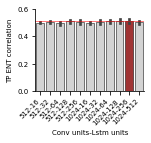


Corresponding data:
              mean       std        se within1se
label                                           
1024-128  0.516651  0.019346  0.008652         *
1024-256  0.516280  0.018289  0.008179         *
512-128   0.511223  0.015819  0.007074         *
1024-64   0.510302  0.015128  0.006766         *
1024-32   0.506769  0.018656  0.008343          
512-32    0.506409  0.008915  0.003987          
512-256   0.506156  0.023201  0.010376          
1024-512  0.503093  0.015449  0.006909          
512-16    0.500342  0.005208  0.002329          
1024-16   0.499081  0.007379  0.003300          
512-64    0.498420  0.013720  0.006136          

T-test for differences in TP ENT corr:
512-16 vs 1024-256 TP ENT corr: pval = 9.78E-02
512-32 vs 1024-256 TP ENT corr: pval = 3.10E-01
512-64 vs 1024-256 TP ENT corr: pval = 1.19E-01
512-128 vs 1024-256 TP ENT corr: pval = 6.53E-01
512-256 vs 1024-256 TP ENT corr: pval = 4.66E-01
1024-16 vs 1024-256 TP ENT corr: pval = 8.70E-02
1024-32 vs 

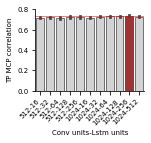


Corresponding data:
              mean       std        se within1se
label                                           
1024-256  0.738252  0.004844  0.002166         *
1024-64   0.730960  0.007330  0.003278          
1024-128  0.730582  0.008012  0.003583          
512-128   0.726457  0.011501  0.005144          
1024-32   0.726199  0.005956  0.002663          
1024-512  0.724239  0.006622  0.002962          
512-256   0.722079  0.011544  0.005163          
512-32    0.721958  0.006906  0.003088          
512-64    0.718491  0.012490  0.005586          
1024-16   0.717968  0.003629  0.001623          
512-16    0.717806  0.008026  0.003589          

T-test for differences in TP MCP corr:
512-16 vs 1024-256 TP MCP corr: pval = 1.23E-03
512-32 vs 1024-256 TP MCP corr: pval = 2.55E-03
512-64 vs 1024-256 TP MCP corr: pval = 1.09E-02
512-128 vs 1024-256 TP MCP corr: pval = 6.75E-02
512-256 vs 1024-256 TP MCP corr: pval = 2.02E-02
1024-16 vs 1024-256 TP MCP corr: pval = 6.97E-05
1024-32 vs 

In [14]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid.loc[scer_grid['conv_units'] > 256], scer_config, 
                              ['conv_units','lstm_units'], '1024-256', xlab_types = [int,int], 
                              control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                              val_line = 'mean', ent_ylim = (0,0.6), mcp_ylim = (0,0.8))


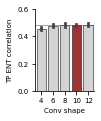


Corresponding data:
                mean       std        se within1se
conv_shape                                        
12          0.486954  0.011830  0.005291         *
8           0.485730  0.015257  0.006823         *
10          0.485143  0.009637  0.004310         *
6           0.479156  0.015699  0.007021          
4           0.456711  0.015503  0.006933          

T-test for differences in TP ENT corr:
   4 vs   10 TP ENT corr: pval = 8.29E-03
   6 vs   10 TP ENT corr: pval = 4.88E-01
   8 vs   10 TP ENT corr: pval = 9.44E-01
  12 vs   10 TP ENT corr: pval = 7.97E-01


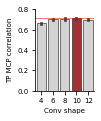


Corresponding data:
                mean       std        se within1se
conv_shape                                        
10          0.711557  0.007575  0.003388         *
8           0.706456  0.011012  0.004925          
6           0.701155  0.007020  0.003140          
12          0.699314  0.009359  0.004185          
4           0.661578  0.002598  0.001162          

T-test for differences in TP MCP corr:
   4 vs   10 TP MCP corr: pval = 6.73E-07
   6 vs   10 TP MCP corr: pval = 5.44E-02
   8 vs   10 TP MCP corr: pval = 4.18E-01
  12 vs   10 TP MCP corr: pval = 5.26E-02


In [15]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, scer_config, 
                            'conv_shape', 10, xlab_type = int,
                            control_seed = 'kfold', replicates = 5, 
                            val_line = 'mean', ent_ylim = (0,0.6), mcp_ylim = (0,0.8))


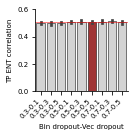


Corresponding data:
             mean       std        se within1se
label                                          
0.7-0.3  0.513140  0.011203  0.005010         *
0.7-0.1  0.510369  0.014574  0.006518         *
0.5-0.3  0.509942  0.014228  0.006363         *
0.5-0.5  0.508685  0.008992  0.004021         *
0.5-0.1  0.504558  0.012421  0.005555          
0.7-0.5  0.503936  0.015404  0.006889          
0.3-0.1  0.499136  0.011484  0.005136          
0.3-0.5  0.498184  0.008526  0.003813          
0.3-0.3  0.497067  0.016753  0.007492          

T-test for differences in TP ENT corr:
0.3-0.1 vs 0.5-0.5 TP ENT corr: pval = 1.81E-01
0.3-0.3 vs 0.5-0.5 TP ENT corr: pval = 2.09E-01
0.3-0.5 vs 0.5-0.5 TP ENT corr: pval = 9.47E-02
0.5-0.1 vs 0.5-0.5 TP ENT corr: pval = 5.64E-01
0.5-0.3 vs 0.5-0.5 TP ENT corr: pval = 8.72E-01
0.7-0.1 vs 0.5-0.5 TP ENT corr: pval = 8.31E-01
0.7-0.3 vs 0.5-0.5 TP ENT corr: pval = 5.08E-01
0.7-0.5 vs 0.5-0.5 TP ENT corr: pval = 5.68E-01


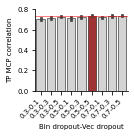


Corresponding data:
             mean       std        se within1se
label                                          
0.5-0.5  0.739310  0.008606  0.003849         *
0.7-0.5  0.737622  0.007934  0.003548         *
0.7-0.3  0.735211  0.010683  0.004778          
0.3-0.5  0.728738  0.007413  0.003315          
0.5-0.3  0.727437  0.009280  0.004150          
0.7-0.1  0.721475  0.009202  0.004115          
0.3-0.3  0.718549  0.011497  0.005141          
0.5-0.1  0.712684  0.018384  0.008221          
0.3-0.1  0.705278  0.013375  0.005981          

T-test for differences in TP MCP corr:
0.3-0.1 vs 0.5-0.5 TP MCP corr: pval = 1.38E-03
0.3-0.3 vs 0.5-0.5 TP MCP corr: pval = 1.20E-02
0.3-0.5 vs 0.5-0.5 TP MCP corr: pval = 7.10E-02
0.5-0.1 vs 0.5-0.5 TP MCP corr: pval = 1.89E-02
0.5-0.3 vs 0.5-0.5 TP MCP corr: pval = 6.92E-02
0.7-0.1 vs 0.5-0.5 TP MCP corr: pval = 1.33E-02
0.7-0.3 vs 0.5-0.5 TP MCP corr: pval = 5.23E-01
0.7-0.5 vs 0.5-0.5 TP MCP corr: pval = 7.55E-01


In [16]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid.loc[scer_grid['bin_dropout'] > 0.1], scer_config, 
                              ['bin_dropout','vec_dropout'], '0.5-0.5', xlab_types = [float,float], 
                              control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                              val_line = 'mean', ent_ylim = (0,0.6), mcp_ylim = (0,0.8))


#### Best configuration

In [17]:
scer_reps = pd.read_csv(os.path.join(RESOURCES, 'polyacleavage_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_reps = scer_reps.loc[(scer_reps['modeltype'] == 'configs')].copy()
print(scer_reps.shape)


(20, 21)


In [18]:
scer_reps['tp_ent_rank'] = scer_reps['tp_ent_corr'].rank(ascending = False, method = 'min')
scer_reps['tp_mcp_rank'] = scer_reps['tp_mcp_corr'].rank(ascending = False, method = 'min')

scer_reps['overall_rank'] = scer_reps['tp_ent_rank'] + scer_reps['tp_mcp_rank']
scer_reps.sort_values('tp_ent_rank').head()


,species,stamp,dataset,genomic_As,positive_sites,negative_seed,split_seed,modeltype,architecture,sequence_size,...,lstm_units,learning_rate,kernel_initializer,max_training_epochs,ideal_epoch,tp_ent_corr,tp_mcp_corr,tp_ent_rank,tp_mcp_rank,overall_rank
274,saccharomyces_cerevisiae,20240423-152708,/projects/b1080/eks/polyadenylation/yeast/sacc...,redistA,NaN,NaN,NaN,configs,cleavage0a,500.0,...,256.0,0.001,zeros,200,29,0.599615,0.759247,1.0,7.0,8.0
284,saccharomyces_cerevisiae,20240423-152812,/projects/b1080/eks/polyadenylation/yeast/sacc...,redistA,NaN,NaN,NaN,configs,cleavage0a,500.0,...,256.0,0.001,zeros,200,28,0.597786,0.761920,2.0,4.0,6.0
278,saccharomyces_cerevisiae,20240423-152735,/projects/b1080/eks/polyadenylation/yeast/sacc...,redistA,NaN,NaN,NaN,configs,cleavage0a,500.0,...,256.0,0.001,zeros,200,24,0.597565,0.754234,3.0,12.0,15.0
279,saccharomyces_cerevisiae,20240423-152744,/projects/b1080/eks/polyadenylation/yeast/sacc...,redistA,NaN,NaN,NaN,configs,cleavage0a,500.0,...,256.0,0.001,zeros,200,44,0.595423,0.763768,4.0,1.0,5.0
280,saccharomyces_cerevisiae,20240423-152749,/projects/b1080/eks/polyadenylation/yeast/sacc...,redistA,NaN,NaN,NaN,configs,cleavage0a,500.0,...,256.0,0.001,zeros,200,38,0.593310,0.760316,5.0,5.0,10.0


In [19]:
scer_reps.sort_values('tp_ent_rank').iloc[0]

species                                         saccharomyces_cerevisiae
stamp                                                    20240423-152708
dataset                /projects/b1080/eks/polyadenylation/yeast/sacc...
genomic_As                                                       redistA
positive_sites                                                       NaN
negative_seed                                                        NaN
split_seed                                                           NaN
modeltype                                                        configs
architecture                                                  cleavage0a
sequence_size                                                        500
bin_dropout                                                          0.7
vec_dropout                                                          0.3
conv_units                                                          1024
conv_shape                                         